In [1]:
import numpy as np # for mathematical operations
import pandas as pd # for reading csv
%matplotlib inline
import matplotlib.pyplot as plt # for plotting the images
import math # for mathematical operations
import cv2 # for capturing videos
from skimage.transform import resize # for resizing images
from keras.preprocessing import image # for preprocessing the images
from keras.utils import np_utils # for encoding
from sklearn.metrics import confusion_matrix, classification_report # for evaluation
import seaborn as sns # for plotting results

In [2]:
# Definition of Artificial Neural Network for Classification
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Dropout

def ANN(X_train, X_valid, y_train, y_valid, n_features, epochs):
    # i. Build the model
    model = Sequential()
    model.add(InputLayer((n_features,))) # input layer
    model.add(Dense(units=1024, activation='relu')) # hidden layer
    model.add(Dropout(0.5))      # adding dropout
    model.add(Dense(units=512, activation='relu')) # hidden layer
    model.add(Dropout(0.5))      # adding dropout
    model.add(Dense(units=256, activation='relu')) # hidden layer
    model.add(Dropout(0.5))      # adding dropout
    model.add(Dense(3, activation='softmax'))  # output layer
    model.summary()

    # ii. Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # iii. Train the model
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid))
    
    # plot training and validation accuracy at each epoch
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'y', label = 'Training acc')
    plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    return model

In [3]:
# Video handling and image extraction
count = 0
videoFile = "Demon Slayer clips.mp4" 
cap = cv2.VideoCapture(videoFile)   # capturing video
frameRate = cap.get(cv2.CAP_PROP_FPS) # get video fps
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1 # create filename
        cv2.imwrite(filename, frame) # write
cap.release()
print ("Image extraction successful!")

Image extraction successful!


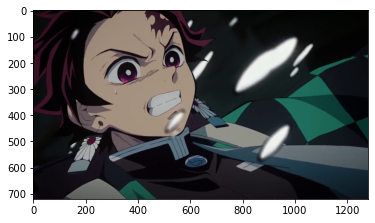

In [4]:
img = plt.imread('frame267.jpg')
plt.imshow(img) # show image

In [5]:
# Class 0 (none), class 1 (Tanjiro), class 2 (Nezuko)
data = pd.read_csv('Demon Slayer clips labels.csv') # read csv file
data.head() # show some labels

,Image_ID,Class
0,frame0.jpg,1
1,frame1.jpg,1
2,frame2.jpg,2
3,frame3.jpg,2
4,frame4.jpg,1


In [6]:
# Store labels
y = data.Class
y.value_counts()

1    205
0    182
2    154
Name: Class, dtype: int64

In [7]:
# images to numpy array
X = [ ]
for img_name in data.Image_ID:
    img = plt.imread('' + img_name)
    X.append(img)  
X = np.array(X)
# reshape images
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    image.append(a)
X = np.array(image)
X.shape

(541, 224, 224, 3)

In [8]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

In [9]:
# normalize
X_train, X_valid = X_train/255.0, X_valid/255.0

In [10]:
# Extracting features using VGG16 model
from keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_model.layers: 
    layer.trainable = False

X_train_vgg = vgg_model.predict(X_train)
X_valid_vgg = vgg_model.predict(X_valid)

# to 1D array (know number of features)
X_train_vgg = X_train_vgg.reshape(X_train_vgg.shape[0], -1)
X_valid_vgg = X_valid_vgg.reshape(X_valid_vgg.shape[0], -1)
X_train_vgg.shape, X_valid_vgg.shape

((432, 25088), (109, 25088))

In [11]:
# Extracting features using InceptionV3 model
from keras.applications.inception_v3 import InceptionV3
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in inception_model.layers: 
    layer.trainable = False

X_train_inc = inception_model.predict(X_train)
X_valid_inc = inception_model.predict(X_valid)

# to 1D array (know number of features)
X_train_inc = X_train_inc.reshape(X_train_inc.shape[0], -1)
X_valid_inc = X_valid_inc.reshape(X_valid_inc.shape[0], -1)
X_train_inc.shape, X_valid_inc.shape

((432, 51200), (109, 51200))

In [12]:
# value counts
y_train.value_counts(), y_valid.value_counts()

(1    155
 0    145
 2    132
 Name: Class, dtype: int64,
 1    50
 0    37
 2    22
 Name: Class, dtype: int64)

In [13]:
# SMOTE oversampling
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [15]:
# oversampling for vgg
X_train_vgg_sm, y_train_vgg_sm = smote.fit_resample(X_train_vgg,y_train)
X_valid_vgg_sm, y_valid_vgg_sm = smote.fit_resample(X_valid_vgg,y_valid)
y_train_vgg_sm.value_counts(), y_valid_vgg_sm.value_counts()

(1    155
 2    155
 0    155
 Name: Class, dtype: int64,
 2    50
 1    50
 0    50
 Name: Class, dtype: int64)

In [16]:
# oversampling for inception
X_train_inc_sm, y_train_inc_sm = smote.fit_resample(X_train_inc,y_train)
X_valid_inc_sm, y_valid_inc_sm = smote.fit_resample(X_valid_inc,y_valid)
y_train_inc_sm.value_counts(), y_valid_inc_sm.value_counts()

(1    155
 2    155
 0    155
 Name: Class, dtype: int64,
 2    50
 1    50
 0    50
 Name: Class, dtype: int64)

In [17]:
# One hot encode labels to use with ANN model
y_train_vgg_sm_e = np_utils.to_categorical(y_train_vgg_sm)
y_valid_vgg_sm_e = np_utils.to_categorical(y_valid_vgg_sm)
y_train_inc_sm_e = np_utils.to_categorical(y_train_inc_sm)
y_valid_inc_sm_e = np_utils.to_categorical(y_valid_inc_sm)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 7

15/15 [==============================] - 2s 105ms/step - loss: 0.1166 - accuracy: 0.9548 - val_loss: 0.4746 - val_accuracy: 0.8733
Epoch 50/100
15/15 [==============================] - 2s 110ms/step - loss: 0.0583 - accuracy: 0.9742 - val_loss: 0.4830 - val_accuracy: 0.8667
Epoch 51/100
15/15 [==============================] - 2s 119ms/step - loss: 0.0946 - accuracy: 0.9677 - val_loss: 0.3922 - val_accuracy: 0.8600
Epoch 52/100
15/15 [==============================] - 2s 119ms/step - loss: 0.0993 - accuracy: 0.9677 - val_loss: 0.4103 - val_accuracy: 0.8733
Epoch 53/100
15/15 [==============================] - 2s 101ms/step - loss: 0.0933 - accuracy: 0.9570 - val_loss: 0.5777 - val_accuracy: 0.8533
Epoch 54/100
15/15 [==============================] - 2s 104ms/step - loss: 0.1374 - accuracy: 0.9505 - val_loss: 0.4337 - val_accuracy: 0.8800
Epoch 55/100
15/15 [==============================] - 2s 106ms/step - loss: 0.1304 - accuracy: 0.9548 - val_loss: 0.6836 - val_accuracy: 0.8333
Epoch

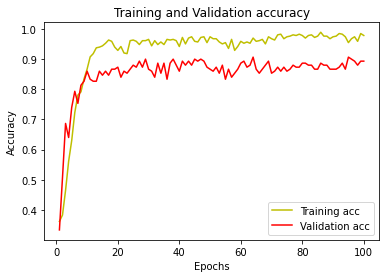

In [18]:
# ANN classification model using VGG16 extracted features
vgg_ANN_model = ANN(X_train_vgg_sm, X_valid_vgg_sm, y_train_vgg_sm_e, y_valid_vgg_sm_e, 25088, 100)

VGG16 as feature extractor 
Classification report: 
               precision    recall  f1-score   support

           0       0.93      0.86      0.90        50
           1       0.88      0.86      0.87        50
           2       0.87      0.96      0.91        50

    accuracy                           0.89       150
   macro avg       0.90      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150

Confusion matrix: 
 AxesSubplot(0.125,0.125;0.62x0.755)


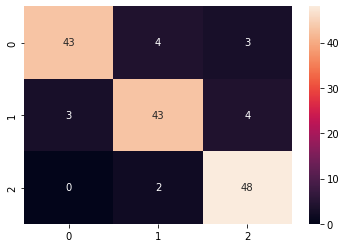

In [21]:
# Results of ANN classification model using VGG16 extracted features
y_vgg_pred = np.argmax(vgg_ANN_model.predict(X_valid_vgg_sm), axis=-1)

cm = confusion_matrix(y_valid_vgg_sm, y_vgg_pred)
print("VGG16 as feature extractor \nClassification report: \n", classification_report(y_valid_vgg_sm, y_vgg_pred))
print("Confusion matrix: \n", sns.heatmap(cm, annot=True))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              52429824  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                

Epoch 49/100
15/15 [==============================] - 3s 196ms/step - loss: 0.0584 - accuracy: 0.9914 - val_loss: 1.2416 - val_accuracy: 0.8533
Epoch 50/100
15/15 [==============================] - 3s 202ms/step - loss: 0.1990 - accuracy: 0.9806 - val_loss: 1.0674 - val_accuracy: 0.8800
Epoch 51/100
15/15 [==============================] - 3s 192ms/step - loss: 0.0630 - accuracy: 0.9849 - val_loss: 1.0766 - val_accuracy: 0.8933
Epoch 52/100
15/15 [==============================] - 3s 201ms/step - loss: 0.1257 - accuracy: 0.9763 - val_loss: 1.1605 - val_accuracy: 0.8733
Epoch 53/100
15/15 [==============================] - 3s 191ms/step - loss: 0.1570 - accuracy: 0.9742 - val_loss: 1.3266 - val_accuracy: 0.8733
Epoch 54/100
15/15 [==============================] - 3s 197ms/step - loss: 0.1648 - accuracy: 0.9935 - val_loss: 1.3740 - val_accuracy: 0.8733
Epoch 55/100
15/15 [==============================] - 3s 223ms/step - loss: 0.2428 - accuracy: 0.9806 - val_loss: 1.4280 - val_accuracy:

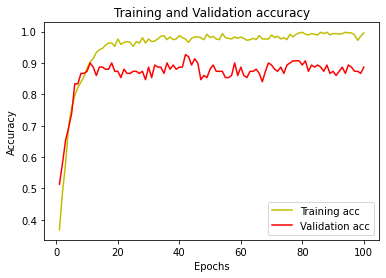

In [20]:
# ANN classification model using InceptionV3 extracted features
inception_ANN_model = ANN(X_train_inc_sm, X_valid_inc_sm, y_train_inc_sm_e, y_valid_inc_sm_e, 51200, 100)

InceptionV3 as feature extractor 
Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.94      0.88      0.91        50
           2       0.91      0.86      0.89        50

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150

Confusion matrix: 
 AxesSubplot(0.125,0.125;0.62x0.755)


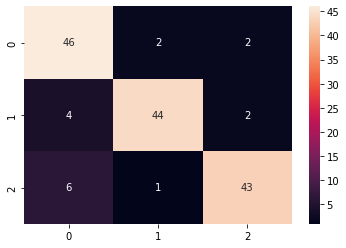

In [22]:
# Results of ANN classification model using InceptionV3 extracted features
y_inc_pred = np.argmax(inception_ANN_model.predict(X_valid_inc_sm), axis=-1)

cm = confusion_matrix(y_valid_inc_sm, y_inc_pred)
print("InceptionV3 as feature extractor \nClassification report: \n", classification_report(y_valid_inc_sm, y_inc_pred))
print("Confusion matrix: \n", sns.heatmap(cm, annot=True))

In [23]:
# Import XGBoost to compare  
import xgboost as xgb

VGG16 as feature extractor 
Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.90      0.91        50
           1       0.96      0.88      0.92        50
           2       0.85      0.94      0.90        50

    accuracy                           0.91       150
   macro avg       0.91      0.91      0.91       150
weighted avg       0.91      0.91      0.91       150

Confusion matrix: 
 AxesSubplot(0.125,0.125;0.62x0.755)


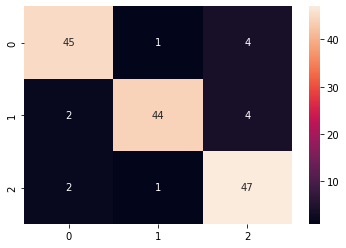

In [24]:
# XGBoost classification model using VGG16 extracted features
vgg_xgb_model = xgb.XGBClassifier(use_label_encoder =False)

vgg_xgb_model.fit(X_train_vgg_sm, y_train_vgg_sm, eval_metric='mlogloss')
y_vgg_pred = vgg_xgb_model.predict(X_valid_vgg_sm)

# Results
cm = confusion_matrix(y_valid_vgg_sm, y_vgg_pred)
print("VGG16 as feature extractor \nClassification report: \n", classification_report(y_valid_vgg_sm, y_vgg_pred))
print("Confusion matrix: \n", sns.heatmap(cm, annot=True))

InceptionV3 as feature extractor 
Classification report: 
               precision    recall  f1-score   support

           0       0.87      0.94      0.90        50
           1       0.92      0.88      0.90        50
           2       0.88      0.84      0.86        50

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150

Confusion matrix: 
 AxesSubplot(0.125,0.125;0.62x0.755)


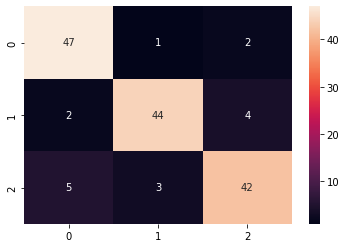

In [55]:
# XGBoost classification model using InceptionV3 extracted features
inc_xgb_model = xgb.XGBClassifier(use_label_encoder =False)

inc_xgb_model.fit(X_train_inc_sm, y_train_inc_sm, eval_metric='mlogloss')
y_inc_pred = inc_xgb_model.predict(X_valid_inc_sm)

# Results
cm = confusion_matrix(y_valid_inc_sm, y_inc_pred)
print("InceptionV3 as feature extractor \nClassification report: \n", classification_report(y_valid_inc_sm, y_inc_pred))
print("Confusion matrix: \n", sns.heatmap(cm, annot=True))

In [26]:
# INFERENCE STEP - Using the models in real application
# Video to analyze
count = 0
videoFile = "Demon Slayer episode 19.mp4" 
cap = cv2.VideoCapture(videoFile)   # capturing video
frameRate = cap.get(cv2.CAP_PROP_FPS) # get video fps
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="testframe%d.jpg" % count;count+=1 # create filename
        cv2.imwrite(filename, frame) # write
cap.release()
print ("Image extraction successful!")

Image extraction successful!


In [27]:
# read image filenames
test = pd.read_csv('Demon Slayer episode 19 test_IDs.csv')
# images to numpy array
test_image = []
for img_name in test.Image_ID:
    img = plt.imread('' + img_name)
    test_image.append(img)
test_img = np.array(test_image)
# reshape images
test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)

In [28]:
# Preprocess images (VGG16)
# normalize
test_image_vgg = test_image/255.0

# extracting features from the images using pretrained model
test_image_vgg = vgg_model.predict(test_image_vgg)

# converting the images to 1-D form
test_image_vgg = test_image_vgg.reshape(test_image_vgg.shape[0], -1)

In [63]:
# Screen Time results using VGG16 and ANN 
vgg_ANN_pred = np.argmax(vgg_ANN_model.predict(test_image_vgg), -1)
print("The screen time of Tanjiro (class 1) in episode 19 is", vgg_ANN_pred[vgg_ANN_pred==1].shape[0], "seconds")
print("The screen time of Nezuko (class 2) in episode 19 is", vgg_ANN_pred[vgg_ANN_pred==2].shape[0], "seconds")

The screen time of Tanjiro (class 1) in episode 19 is 604 seconds
The screen time of Nezuko (class 2) in episode 19 is 342 seconds


In [64]:
# Screen Time results using VGG16 and XGBoost 
vgg_xgb_pred = vgg_xgb_model.predict(test_image_vgg)
print("The screen time of Tanjiro (class 1) in episode 19 is", vgg_xgb_pred[vgg_xgb_pred==1].shape[0], "seconds")
print("The screen time of Nezuko (class 2) in episode 19 is", vgg_xgb_pred[vgg_xgb_pred==2].shape[0], "seconds")

The screen time of Tanjiro (class 1) in episode 19 is 640 seconds
The screen time of Nezuko (class 2) in episode 19 is 371 seconds


In [31]:
# Preprocess images (InceptionV3)
# normalize
test_image_inc = test_image/255.0

# extracting features from the images using pretrained model
test_image_inc = inception_model.predict(test_image_inc)

# converting the images to 1-D form
test_image_inc = test_image_inc.reshape(test_image_inc.shape[0], -1)

In [65]:
# Screen Time results using InceptionV3 and ANN 
inc_ANN_pred = np.argmax(inception_ANN_model.predict(test_image_inc), -1)
print("The screen time of Tanjiro (class 1) in episode 19 is", inc_ANN_pred[inc_ANN_pred==1].shape[0], "seconds")
print("The screen time of Nezuko (class 2) in episode 19 is", inc_ANN_pred[inc_ANN_pred==2].shape[0], "seconds")

The screen time of Tanjiro (class 1) in episode 19 is 599 seconds
The screen time of Nezuko (class 2) in episode 19 is 188 seconds


In [66]:
# Screen Time results using InceptionV3 and XGBoost 
inc_xgb_pred = inc_xgb_model.predict(test_image_inc)
print("The screen time of Tanjiro (class 1) in episode 19 is", inc_xgb_pred[inc_xgb_pred==1].shape[0], "seconds")
print("The screen time of Nezuko (class 2) in episode 19 is", inc_xgb_pred[inc_xgb_pred==2].shape[0], "seconds")

The screen time of Tanjiro (class 1) in episode 19 is 658 seconds
The screen time of Nezuko (class 2) in episode 19 is 229 seconds


In [34]:
# read test labels
test_data = pd.read_csv('Demon Slayer episode 19 labels.csv')
# Store labels
y_real = test_data.Class
y_real_e = np_utils.to_categorical(y_real)
y_real.value_counts()

0    825
1    518
2    139
Name: Class, dtype: int64